# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

src_path = os.path.abspath("../")
sys.path.append(src_path)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
from src.classification.data_augmentation import DataAugmentation, rotate_image, translate_image, scale_image, perspective_transform, adjust_brightness, adjust_contrast, adjust_saturation, add_noise, process_images_with_augmentation
from src.classification.train import CustomImageDataset, get_data_loaders, train_model

# Data Augmentation

In [6]:
augmenter = DataAugmentation([{"func": rotate_image}, {"func": scale_image}, {"func": perspective_transform}, {"func": adjust_brightness}, {"func": adjust_contrast}, {"func": adjust_saturation}, {"func": add_noise}], seed=42)
process_images_with_augmentation(r"../data/raw/images", r"../data/augmented/images", augmenter, r"../data/raw/product_list.csv", r"../data/augmented/product_list.csv")

Processed and saved augmentations for: 010M03A1116X9000.jpeg
Processed and saved augmentations for: 010M09A1101X0863.jpeg
Processed and saved augmentations for: 010M27A0006X0200.jpeg
Processed and saved augmentations for: 011A11A1166X4150.jpeg
Processed and saved augmentations for: 011A11A1166X9000.jpeg
Processed and saved augmentations for: 011B13A6014X0200.jpeg
Processed and saved augmentations for: 011B48A3874X0863.jpeg
Processed and saved augmentations for: 011D01A1166X5645.jpeg
Processed and saved augmentations for: 011D01A1166X9000.jpeg
Processed and saved augmentations for: 011D02A1166X3250.jpeg
Processed and saved augmentations for: 011G05ACMIXX0863.jpeg
Processed and saved augmentations for: 011G07A1166X9000.jpeg
Processed and saved augmentations for: 011G12A1166X4150.jpeg
Processed and saved augmentations for: 011G13A1212X0200.jpeg
Processed and saved augmentations for: 011J12A1166X9000.jpeg
Processed and saved augmentations for: 011J22X8801X9000.jpeg
Processed and saved augm

# Training

In [7]:
csv_file = r"../data/augmented/product_list.csv"
folder_path = r"../data/augmented/images/"

# Get data loaders
train_loader, val_loader = get_data_loaders(csv_file, folder_path)

In [8]:
from torchvision import transforms, models
print("Loading pre-trained ResNet-18...")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


Loading pre-trained ResNet-18...


In [9]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Modify the final layer for the number of classes in your dataset
num_classes = len(pd.read_csv(csv_file).iloc[:, 1].unique())
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
model = model.to(device)

In [12]:
import torch.optim as optim

In [13]:
# Fine-tune specific layers
layers_to_finetune = ['fc.weight', 'fc.bias', 'layer4.1.conv2.weight', 'layer4.1.bn2.weight', 'layer4.1.bn2.bias']
params_to_update = []
for name, param in model.named_parameters():
    if name in layers_to_finetune:
        print(f"Fine-tuning: {name}")
        params_to_update.append(param)
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=1e-4)

Fine-tuning: layer4.1.conv2.weight
Fine-tuning: layer4.1.bn2.weight
Fine-tuning: layer4.1.bn2.bias
Fine-tuning: fc.weight
Fine-tuning: fc.bias


In [14]:
# Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=10)

Epoch 1/10
Train Loss: 0.2461, Validation Loss: 0.0995
Epoch 2/10
Train Loss: 0.1023, Validation Loss: 0.0641
Epoch 3/10
Train Loss: 0.0678, Validation Loss: 0.0449
Epoch 4/10
Train Loss: 0.0487, Validation Loss: 0.0400
Epoch 5/10
Train Loss: 0.0361, Validation Loss: 0.0328
Epoch 6/10
Train Loss: 0.0268, Validation Loss: 0.0278
Epoch 7/10
Train Loss: 0.0217, Validation Loss: 0.0257
Epoch 8/10
Train Loss: 0.0173, Validation Loss: 0.0228
Epoch 9/10
Train Loss: 0.0150, Validation Loss: 0.0208
Epoch 10/10
Train Loss: 0.0132, Validation Loss: 0.0187


In [16]:
torch.save(model.state_dict(), "../models/classification/model.pth")


# Evaluation

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader, random_split

In [24]:
import os
import pandas as pd

def verify_images_in_csv(csv_file, image_dir, output_csv):
    data = pd.read_csv(csv_file)

    valid_entries = []
    for _, row in data.iterrows():
        image_path = os.path.join(image_dir, row[0])
        if os.path.exists(image_path):
            valid_entries.append(row)
        else:
            print(f"Imagem ausente: {row[0]}")

    valid_data = pd.DataFrame(valid_entries, columns=data.columns)

    valid_data.to_csv(output_csv, index=False)
    print(f"CSV atualizado salvo em: {output_csv}")


In [25]:
verify_images_in_csv("../data/raw/product_list.csv", "../data/raw/images/", "../data/raw/post_processed.csv")

C:\Users\merte\AppData\Local\Temp\ipykernel_1376\3601028893.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = os.path.join(image_dir, row[0])
C:\Users\merte\AppData\Local\Temp\ipykernel_1376\3601028893.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Imagem ausente: {row[0]}")


Imagem ausente: CD040112A0030000.jpeg
CSV atualizado salvo em: ../data/raw/post_processed.csv


In [40]:
def evaluate_and_plot(csv_file, image_dir, model, batch_size=32):
    # Transformações consistentes
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    dataset = CustomImageDataset(csv_file, image_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    model.to(device)
    
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    class_names = dataset.idx_to_class.values()
    
    print("Classification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    print(report)
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Classification Report:
               precision    recall  f1-score   support

        W RTW       1.00      1.00      1.00       627
        W SLG       1.00      1.00      1.00       302
       W Bags       1.00      1.00      1.00       830
      W Shoes       1.00      1.00      1.00       336
      Watches       1.00      1.00      1.00       128
W Accessories       1.00      1.00      1.00       543

     accuracy                           1.00      2766
    macro avg       1.00      1.00      1.00      2766
 weighted avg       1.00      1.00      1.00      2766



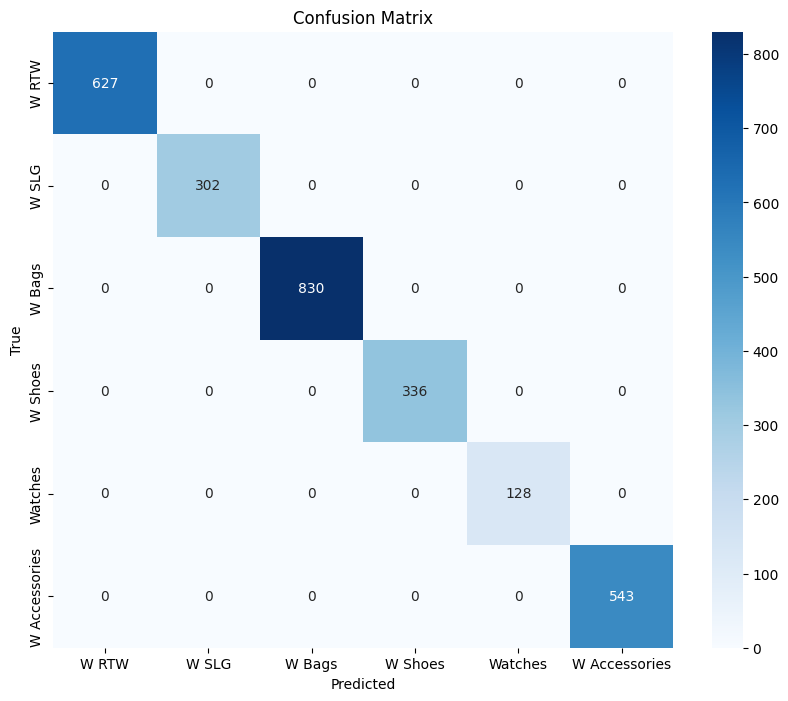

In [28]:
evaluate_and_plot("../data/raw/post_processed.csv", "../data/raw/images/", model)

Classification Report:
               precision    recall  f1-score   support

       W Bags       0.25      0.03      0.06        29
      W Shoes       0.09      0.04      0.05        28
W Accessories       0.00      0.00      0.00        20
      Watches       0.00      0.00      0.00         3
        W SLG       0.00      0.00      0.00         1
        W RTW       0.00      0.00      0.00         1

     accuracy                           0.02        82
    macro avg       0.06      0.01      0.02        82
 weighted avg       0.12      0.02      0.04        82



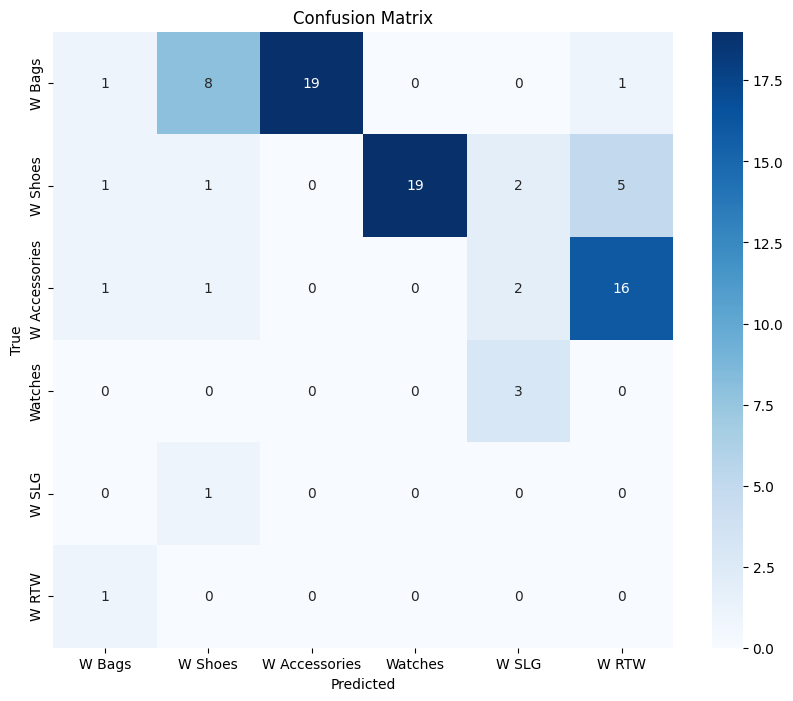

In [41]:
evaluate_and_plot("../data/test/labels.csv", "../data/test/images/", model)